# Multi-LoRA


Now, how to efficiently serve dozens of fine-tuned models together in a single deployment without sacrificing latency!

### Importing required packages

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

### Creating a new model

We will start with creating an extension to the model from lesson 5. It has a custom helper function for computing the LoRA layer step with multiple LoRAs per batch.

In [2]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

### Using a loop

A naive approach will be to loop over every row in the batch and apply the correct LoRA using an index mapping: `batch_index --> lora_index`.

In [3]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [4]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [5]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [6]:
torch.manual_seed(42)

In [7]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [8]:
model = LoopMultiLoraModel()

### Testing the deployment

If the multi-LoRA generation process is working as designed, it shoould generate a variety of different outputs as it randomly iterate over the LoRAs.

In [9]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


### Benchmark the multi-LoRA system!

Measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [10]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

In [11]:
avg_latencies_loop = benchmark(model)

1 4.143285751342774e-05
2 5.118560791015625e-05
3 5.9067249298095705e-05
4 6.869220733642578e-05
5 7.905244827270508e-05
6 8.589601516723633e-05
7 0.00011393356323242188
8 0.00011606550216674805
9 0.00012598752975463866
10 0.0001268916130065918
11 0.00014242744445800782
12 0.00015566015243530273
13 0.00015843725204467773
14 0.0001651153564453125
15 0.00017410707473754884
16 0.0001844959259033203
17 0.00019166994094848633
18 0.00020099878311157225
19 0.00020898103713989257
20 0.00025170135498046875
21 0.0002273116111755371
22 0.00023632192611694336
23 0.00024471616744995117
24 0.00025630855560302736
25 0.00026200389862060546
26 0.0002709245681762695
27 0.0002853827476501465
28 0.00032328033447265623
29 0.00030281686782836914
30 0.0003148036003112793
31 0.00031792163848876954
32 0.00033667469024658203
33 0.0003402767181396484
34 0.00037433242797851564
35 0.00035934877395629885
36 0.0003626422882080078
37 0.0003759765625
38 0.0003840785026550293
39 0.000399045467376709
40 0.00042135810852

### Plotting the latency vs Batch size


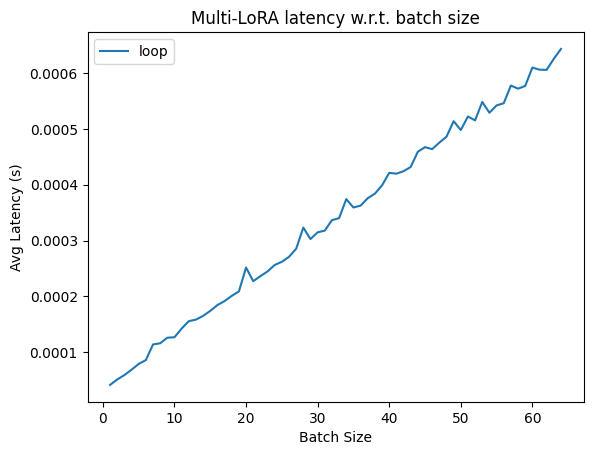

In [12]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

Now, it can be seen that this is not such a scalable approach, and it is avident as by looping over each element in the batch to apply lora, we are essentially removing the benifit of batching.

### let's see if we usee only the base model

In [13]:
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.linear(x)
        x = self.lm_head(x)
        return x

In [14]:
model = SimpleModel()

In [15]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark_simple(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids
                
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

In [16]:
avg_latencies_simple = benchmark_simple(model)

1 3.0322551727294922e-05
2 2.9073238372802733e-05
3 2.941322326660156e-05
4 3.0313491821289064e-05
5 3.221416473388672e-05
6 3.281545639038086e-05
7 3.378009796142578e-05
8 3.481101989746094e-05
9 3.560447692871094e-05
10 3.674030303955078e-05
11 3.8013458251953124e-05
12 3.8259029388427734e-05
13 4.057550430297852e-05
14 4.1372299194335935e-05
15 4.259395599365234e-05
16 4.3008327484130856e-05
17 4.3012142181396486e-05
18 4.405784606933594e-05
19 4.530048370361328e-05
20 4.6224594116210936e-05
21 4.809331893920898e-05
22 5.000782012939453e-05
23 5.1128864288330075e-05
24 5.111551284790039e-05
25 5.206823348999023e-05
26 5.254983901977539e-05
27 5.361604690551758e-05
28 5.524301528930664e-05
29 5.675220489501953e-05
30 6.292867660522461e-05
31 5.870437622070312e-05
32 5.9908390045166016e-05
33 5.968952178955078e-05
34 6.034708023071289e-05
35 6.197738647460937e-05
36 6.720399856567383e-05
37 7.581663131713867e-05
38 6.522607803344726e-05
39 6.566572189331055e-05
40 6.640100479125976e-0

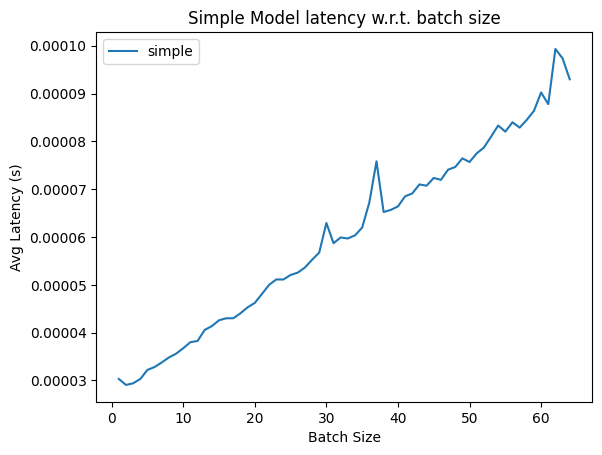

In [18]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_simple, label="simple")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Simple Model latency w.r.t. batch size')
plt.legend()

plt.show()

### Let's vectorize the LoRA computation

We will vectorize the LoRA computation by:

1. Gather the LoRA weight for each batch into a single tensor using `torch.index_select`.
2. Apply LoRA computation once for the entire input tensor.

In [19]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

In [20]:
model = GatheredMultiLoraModel()

In [21]:
avg_latencies_gathered = benchmark(model)

1 4.7475814819335934e-05
2 6.445693969726562e-05
3 5.582475662231445e-05
4 5.367898941040039e-05
5 5.6159019470214844e-05
6 5.746030807495117e-05
7 5.857419967651367e-05
8 5.969333648681641e-05
9 6.0400962829589845e-05
10 6.18143081665039e-05
11 6.377315521240234e-05
12 6.409597396850586e-05
13 6.51249885559082e-05
14 6.702470779418946e-05
15 6.724119186401367e-05
16 6.850337982177735e-05
17 8.708429336547851e-05
18 8.704233169555664e-05
19 7.40365982055664e-05
20 7.471513748168945e-05
21 7.606315612792968e-05
22 7.799053192138672e-05
23 7.844209671020508e-05
24 8.155441284179688e-05
25 8.086585998535156e-05
26 9.186601638793946e-05
27 8.301591873168946e-05
28 8.582448959350586e-05
29 8.944320678710937e-05
30 8.883094787597656e-05
31 8.844280242919922e-05
32 9.073829650878906e-05
33 9.13853645324707e-05
34 9.321928024291992e-05
35 9.352350234985352e-05
36 9.656047821044922e-05
37 9.576988220214843e-05
38 9.962129592895507e-05
39 0.00010642290115356445
40 0.00013093709945678712
41 0.000

### Plotting the latency with vectorization

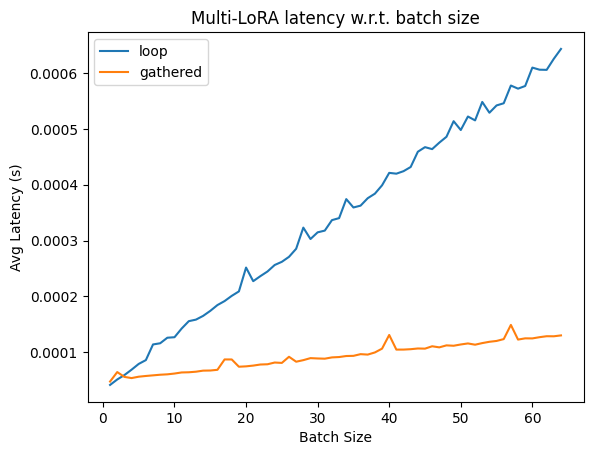

In [22]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

### Plotting the latency vs batch size for base model , looping model and vectorization

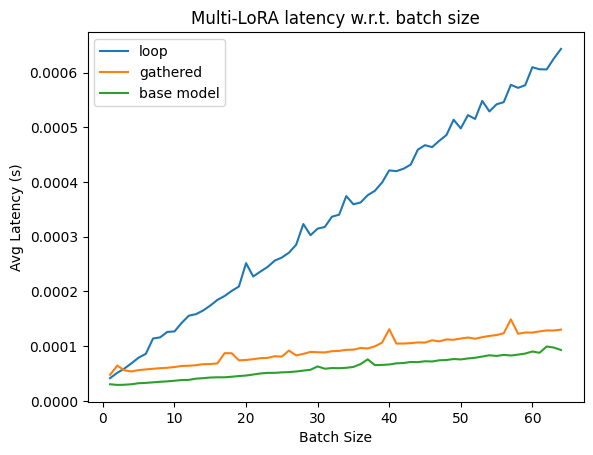

In [23]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")
plt.plot(x, avg_latencies_simple, label="base model")
plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()